In [1]:
import sys
if (path := "C:/Users/Tom/pycharm-projects/python-control") not in sys.path:
    sys.path.append(path)

# Improving Transient Response via Cascade Compensation with Root-Locus Design
---

In [2]:
%matplotlib inline

In [3]:
import sympy as sp
from python_control import s, K, TransferFunction, get_damping_ratio, RootLocus
from python_control.design.root_locus import (
    design_P_feedback,
    design_PD_feedback,
    design_lead_feedback,
    design_unity_feedback
)
from python_control.design import create_second_order_system, plot_step_responses

## Plant Transfer Function

In [4]:
G_p = TransferFunction(
    160 * (s + 2.5) * (s + 0.7)
    / ((s**2 + 5*s + 40) * (s**2 + 0.03*s + 0.06))
)

## Transient Response Requirements

The desired percent overshoot is 30 %. The function `get_damping_ratio` returns the corresponding damping ratio (which is actually only valid in the case of a true second-order system).

In [5]:
percent_overshoot = 10
zeta = get_damping_ratio(percent_overshoot)
print(zeta)

0.5911550337988976


## Design of Uncompensated Unity-Feedback System

Based on the damping ratio value `zeta`, a unity-feedback system is designed with proportional control only. Points are determined where the root locus crosses the damping ratio line (in the upper, positive part of the left-half s-plane). If multiple crossing-points are found, the point closest to the imaginary axis is considered to be the dominant closed-loop pole (its conjugate in the lower, negative part of the left-half s-plane will also be a closed-loop pole of the unity-feedback system). Then, the corresponding value of the gain to get at the dominant closed-loop pole is determined. This gain value is the overall open-loop gain or forward-path gain of the unity-feedback system. The control gain needed from the proportional controller is determined by dividing the overall open-loop gain by the plant gain. 

In [6]:
design_uc = design_P_feedback(
    G_plant=G_p, 
    damping_ratio=zeta,
    name='uncompensated'
)

**Root Locus**<br>
Root locus of the unity-feedback system without any compensation.

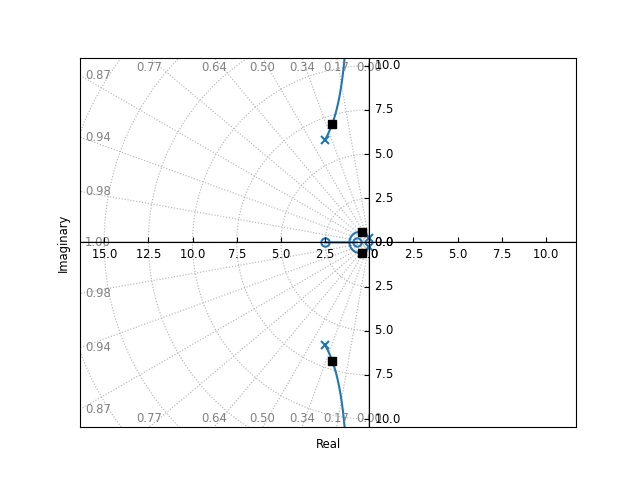

In [7]:
root_locus1 = RootLocus(G_p)
root_locus1.plot(dynamic=True, initial_gain=design_uc.forward_gain)

**P-controller**

Overall forward-path gain:

In [8]:
print(design_uc.forward_gain)

13.478761554961563


Controller gain:

In [9]:
print(design_uc.controller.gain)

0.0842422597185095


**Transient and Steady-State Error Characteristics of the Unity-Feedback System**

In [10]:
print(design_uc.characteristics)

system type: type_0
steady-state error: 0.0924
static error constant: 9.83
steady-state value: 0.908
dc-gain: 0.908
second-order approximation: False
rise time: 1.06
peak time: 3.04
settling time: 9.97
percent overshoot: 22.4


Here we can see that the percent overshoot of the actual system is greater than the value we desire. This is because the relation between damping ratio and percent overshoot of the actual fourth-order system is different than the analytic relation that applies to second-order systems only.

**Comparison between the unit-step response of the actual unity-feedback system and its second-order approximation**

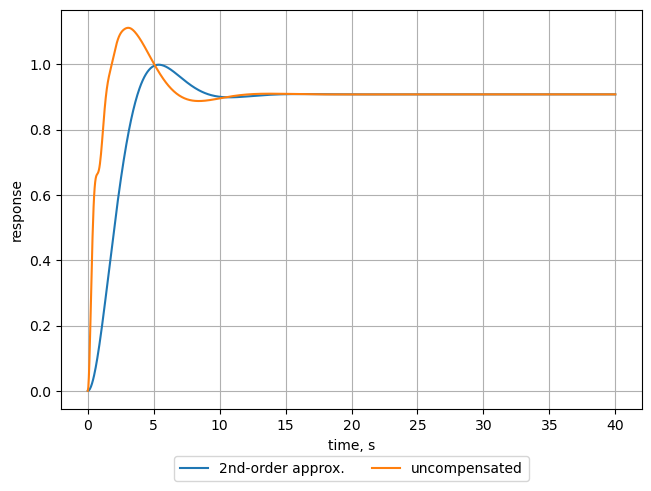

In [11]:
sosys_uc = create_second_order_system(
    dominant_pole=design_uc.feedback_system.dominant_pole_pair[0],
    dc_gain=design_uc.feedback_system.closed_loop.dc_gain,
    name='2nd-order approx.'
)

plot_step_responses(design_uc.feedback_system, sosys_uc, upper_limit=40)

## Design of Compensated Unity-Feedback System

We want to reduce the settling time by a factor of 5.

### With PD-Controller

In [12]:
design_pd = design_PD_feedback(
    settling_time=design_uc.characteristics.settling_time / 5,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    name='PD-feedback'
)

[9164 | python_control.design.root_locus | DEBUG] dominant pole: (-2.006577122316288+2.737726377848351j)
[9164 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 297.12105346794453
[9164 | python_control.design.root_locus | DEBUG] compensator zero: -3.4088121427330393
[9164 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 62.878946532055465
[9164 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 359.99999999999994
C:\Users/Tom/pycharm-projects/python-control\python_control\design\root_locus.py:567: UserWarning: Transient response requirements cannot be met.
  warnings.warn(


**Root Locus**

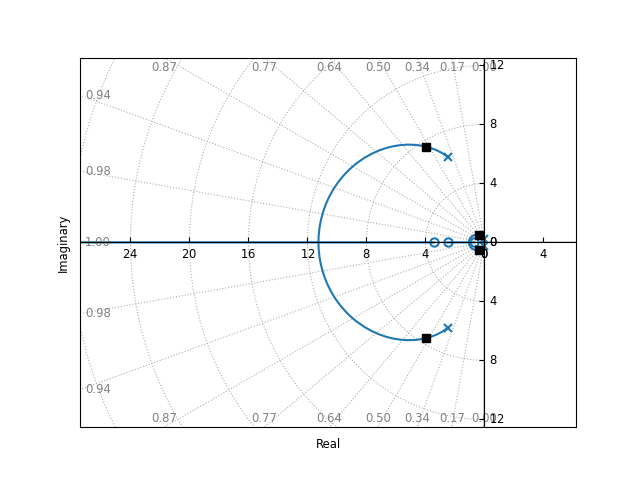

In [13]:
root_locus2 = RootLocus(design_pd.feedback_system.open_loop)
root_locus2.plot(dynamic=True, initial_gain=design_pd.forward_gain)

We receive a user warning that the transient response requirements cannot be fulfilled and we see from the debug log messages that the dominant pole needed to meet the transient response requirements is not on the root locus of the feedback system.

In [14]:
print(design_pd.feedback_system.dominant_pole_pair[0])

(-0.38086102561887597+0.5196377774545928j)


**PD-controller**

Overall forward-path gain (also the open-loop gain in case of a unity-feedback system).

In [15]:
print(design_pd.forward_gain)

3.6085311284362036


Gain that needs to be provided by the PD-controller.

In [16]:
print(design_pd.controller.gain)

0.0225533195527262


In [17]:
print(design_pd.controller_gains.K_p, design_pd.controller_gains.K_d)

0.0768800295502715 0.0225533195527262


In [18]:
design_pd.controller.expr

0.0225533195527262*s + 0.0768800295502715

In [19]:
print(design_pd.controller.zeros)

[-3.40881214+0.j]


**Transient Response and Steady-State Error Characteristics of the PD-controlled Unity-Feedback System**

In [20]:
print(design_pd.characteristics)

system type: type_0
steady-state error: 0.1
static error constant: 8.97
steady-state value: 0.9
dc-gain: 0.9
second-order approximation: True
natural frequency: 0.644
damping ratio: 0.591
rise time: 1.23
peak time: 3.42
settling time: 7.31
percent overshoot: 19.6


**Comparison Between the Unit-Step Responses of the Uncompensated and the PD-Controlled Unity-Feedback System**

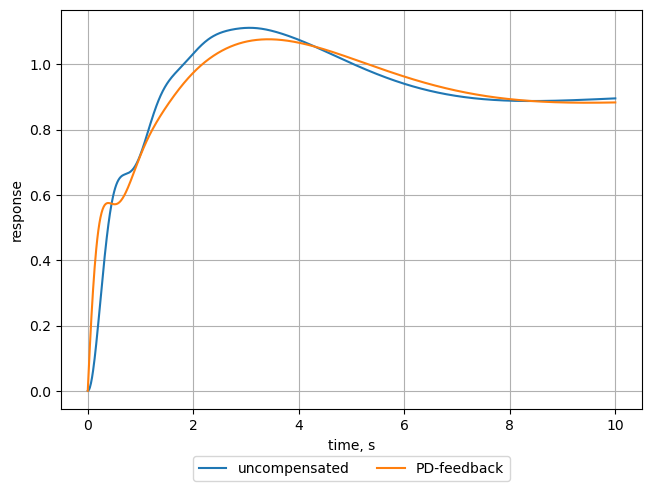

In [21]:
plot_step_responses(design_uc.feedback_system, design_pd.feedback_system)

### With Lead Compensator

We need to select the location of the negative zero on the real axis. The function `design_lead_feedback` will calculate the location of the compensator pole in order that the transient response requirements would be met (which may not always be possible).

In [37]:
design_lead = design_lead_feedback(
    settling_time=design_uc.characteristics.settling_time / 5,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    compensator_zero=-2.0,
    name='lead compensation'
)

[9164 | python_control.design.root_locus | DEBUG] dominant pole: (-2.006577122316288+2.737726377848351j)
[9164 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 297.12105346794453
[9164 | python_control.design.root_locus | DEBUG] LEAD compensator zero: -2.0, pole: -7.320218893034415
[9164 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 90.1376472930718
[9164 | python_control.design.root_locus | DEBUG] angular contribution of compensator pole: 27.258700761016332
[9164 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 359.9999999999999
C:\Users/Tom/pycharm-projects/python-control\python_control\design\root_locus.py:715: UserWarning: Transient response requirements cannot be met.
  warnings.warn(


**Root Locus**

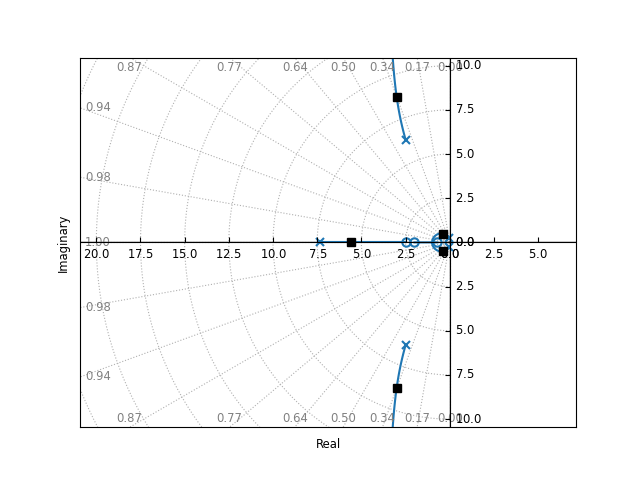

In [38]:
root_locus3 = RootLocus(design_lead.feedback_system.open_loop)
root_locus3.plot(dynamic=True, initial_gain=design_lead.forward_gain)

In [39]:
print(design_lead.feedback_system.dominant_pole_pair[0])

(-0.36674327788896083+0.5003758562821461j)


**Lead Compensator**

In [40]:
print(design_lead.forward_gain)

42.30513939217866


In [41]:
design_lead.controller.expr

(0.264407121201116*s + 0.528814242402231)/(1.0*s + 7.32021889303441)

In [42]:
design_lead.controller.zeros

array([-2.+0.j])

In [43]:
design_lead.controller.poles

[(-7.32021889303441+0j)]

**Transient Response and Steady-State Error Characteristics of the Lead-Compensated Unity-Feedback System**

In [44]:
print(design_lead.characteristics)

system type: type_0
steady-state error: 0.106
static error constant: 8.43
steady-state value: 0.894
dc-gain: 0.894
second-order approximation: True
natural frequency: 0.62
damping ratio: 0.591
rise time: 1.17
peak time: 3.55
settling time: 7.59
percent overshoot: 19.4


**Comparison between the Unit-Step Responses of the Uncompensated, the PD-Controlled, and the Lead-Compensated Unity-Feedback System**

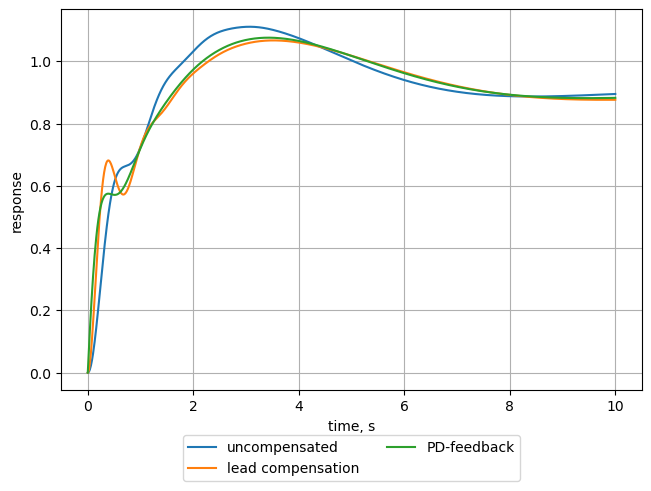

In [45]:
plot_step_responses(
    design_uc.feedback_system, 
    design_lead.feedback_system,
    design_pd.feedback_system
)

### With Lead Compensator Bis

Instead of using the function `design_lead_feedback`, which calculates the location of the compensator pole based on the required transient response requirements and the location of the compensator zero that we specify, we can also design the lead compensator completely by ourselves by selecting both the compensator zero and the compensator pole. Therefore, we define the transfer function of the lead compensator:

In [46]:
KG_c = TransferFunction(K * (s + 3) / (s + 20))

**Creation of the Compensated Unity-Feedback System**

In [47]:
fbsys_lead, K_value = design_unity_feedback(
    KG_c=KG_c, 
    G_plant=G_p, 
    damping_ratio=zeta,
    name='lead compensated bis'
)

In [48]:
print(f"overall forward-path gain = {K_value}")

overall forward-path gain = 81.53649122127442


In [49]:
print(f"settling time = {fbsys_lead.settling_time():.3f} s")

settling time = 7.305 s


In [52]:
print(f"percent overshoot = {fbsys_lead.percent_overshoot():.3f} %")

percent overshoot = 19.738 %


**Root Locus**

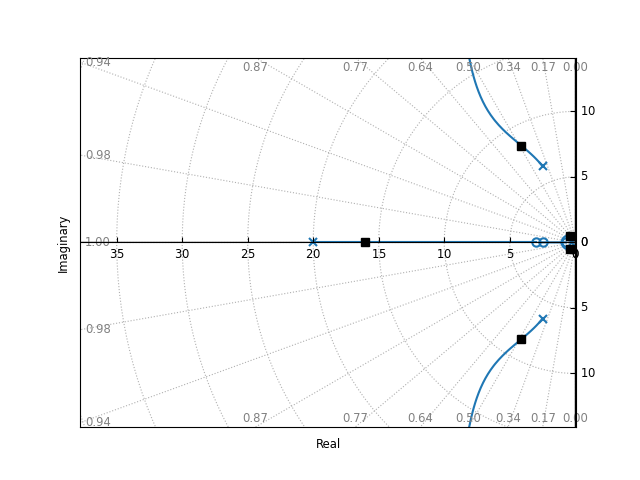

In [50]:
root_locus4 = RootLocus(fbsys_lead.open_loop)
root_locus4.plot(dynamic=True, initial_gain=K_value)

**Comparison between the Unit-Step Responses of the Uncompensated, the PD-Controlled, and the Lead-Compensated Unity-Feedback Systems**

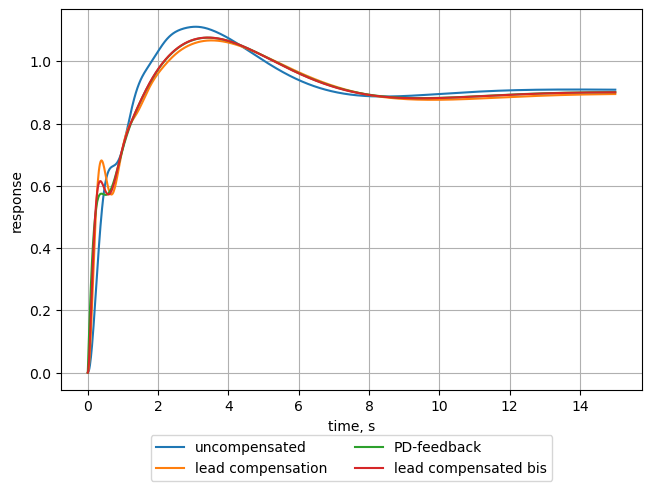

In [53]:
plot_step_responses(
    design_uc.feedback_system, 
    design_lead.feedback_system,
    design_pd.feedback_system,
    fbsys_lead,
    upper_limit=15
)